## Data pre-processing and augmentation ( Experimental )

In [65]:
#Reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from __future__ import print_function, division
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import os
%matplotlib inline 

import matplotlib.pyplot as plt
from PIL import Image
from ipywidgets import interact
from scipy.misc import imresize, imsave
from shutil import copyfile
from skimage.segmentation import mark_boundaries

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
import random

## Initialization

In [3]:
# image dimension of the input images
img_width, img_height = 150, 150

# Download the data from Kaggle https://www.kaggle.com/c/dogs-vs-cats/data?train.zip
# One can do it from CLI using Curl 
## e.g. 1. wget -x -c --load-cookies cookies.txt -nH --cut-dirs=5 https://www.kaggle.com/c/dogs-vs-cats/download/train.zip
##      2. create train and validation folders and respectively unzip the downloaded files
train_data_dir = 'data/dogs_vs_cats/train'
validation_data_dir = 'data/dogs_vs_cats/validation'

# Experiment initialization:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [4]:
from random import randint
def browse_images(dir_path, define_range=10):
    list_of_images = os.listdir(dir_path)
    n = len(list_of_images)
    if define_range > n:
        raise ValueError("out of range")
    def view_image(index):
        im = Image.open('{}{}'.format(dir_path, list_of_images[index]))
        plt.imshow(im, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
    interact(view_image, index=(0, define_range))

# Quick Exploration of the images

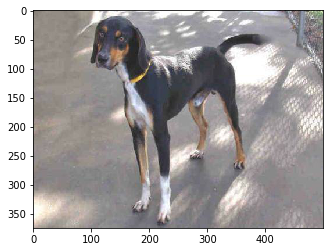

In [5]:
# Explore the dog pictures
browse_images('data/dogs_vs_cats/train/dog/')

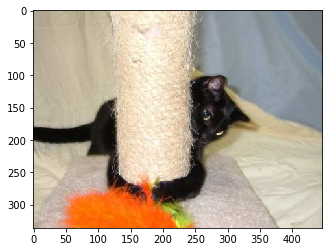

In [6]:
# Explore the cat pictures
browse_images('data/dogs_vs_cats/train/cat/')

## Selecting Backend - Tensorflow or Theano

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

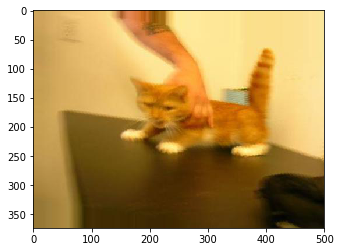

In [8]:
browse_images('data/dogs_vs_cats/preview/')

## Model Architecture

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Data pre-processing

In [91]:
#TODO: Stream-line splitting of train and test in a better way
_image_list_dog = os.listdir('data/dogs_vs_cats/train/dog/')
image_index_list_dog = random.sample(range(len(_image_list_dog)), k=2500)
os.mkdir('data/dogs_vs_cats/train/training_set/dog', 0755 )
os.mkdir('data/dogs_vs_cats/train/validation_set/dog', 0755 )

_image_list_cat = os.listdir('data/dogs_vs_cats/train/cat/')
image_index_list_cat = random.sample(range(len(_image_list_cat)), k=2500)
os.mkdir('data/dogs_vs_cats/train/training_set/cat', 0755 )
os.mkdir('data/dogs_vs_cats/train/validation_set/cat', 0755 )

In [92]:
train_test_split = 0.8
train_split = int(train_test_split*2500)
test_split = int(train_test_split*2500)
image_index_list_dog_train, image_index_list_dog_test = image_index_list_dog[:train_split], image_index_list_dog[train_split:]
image_index_list_cat_train, image_index_list_cat_test = image_index_list_cat[:train_split], image_index_list_cat[train_split:]

In [93]:
def copy_files(image_index_list, file_list, src, dst):
    for index in image_index_list:
        image_name = file_list[index]
        src_path = os.path.join(os.getcwd(),src, image_name)
        dst_path = os.path.join(os.getcwd(), dst, image_name)
        copyfile(src_path, dst_path)

In [94]:
# Training set 
copy_files(image_index_list_dog_train, _image_list_dog, src='data/dogs_vs_cats/train/dog/', 
           dst='data/dogs_vs_cats/train/training_set/dog/')
copy_files(image_index_list_cat_train, _image_list_cat, src='data/dogs_vs_cats/train/cat/', 
           dst='data/dogs_vs_cats/train/training_set/cat/')

# Testing set
copy_files(image_index_list_dog_test, _image_list_dog, src='data/dogs_vs_cats/train/dog/', 
           dst='data/dogs_vs_cats/train/validation_set/dog/')
copy_files(image_index_list_cat_test, _image_list_cat, src='data/dogs_vs_cats/train/cat/', 
           dst='data/dogs_vs_cats/train/validation_set/cat/')

In [10]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'data/dogs_vs_cats/train/training_set/',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        'data/dogs_vs_cats/train/validation_set/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model Training

In [11]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 41s - loss: 0.7050 - acc: 0.5195 - val_loss: 0.6879 - val_acc: 0.6025
Epoch 2/50
125/125 [==============================] - 41s - loss: 0.6894 - acc: 0.5485 - val_loss: 0.6902 - val_acc: 0.5265
Epoch 3/50
125/125 [==============================] - 41s - loss: 0.6630 - acc: 0.6045 - val_loss: 0.6209 - val_acc: 0.6654
Epoch 4/50
125/125 [==============================] - 41s - loss: 0.6419 - acc: 0.6455 - val_loss: 0.6206 - val_acc: 0.6288
Epoch 5/50
125/125 [==============================] - 41s - loss: 0.6248 - acc: 0.6590 - val_loss: 0.5734 - val_acc: 0.7096
Epoch 6/50
125/125 [==============================] - 41s - loss: 0.5924 - acc: 0.6875 - val_loss: 0.5738 - val_acc: 0.7121
Epoch 7/50
125/125 [==============================] - 41s - loss: 0.5665 - acc: 0.7120 - val_loss: 0.5618 - val_acc: 0.6730
Epoch 8/50
125/125 [==============================] - 41s - loss: 0.5742 - acc: 0.7065 - val_loss: 0.6080 - val_acc: 0.6515
Epoch 9/

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [13]:
model.save_weights('a_simple_model.h5')

## Interpreting the Model 

In [14]:
from skater.core.local_interpretation.lime.lime_image import LimeImageExplainer
from skater.model import InMemoryModel

In [58]:
def image_resizing(img_file):
    img_as_arry = img_to_array(img_file)
    resized = imresize(img_as_arry, (img_width, img_height))
    an_img = resized.reshape((1,) + resized.shape)
    return an_img

(1, 150, 150, 3)


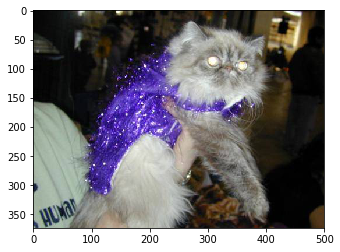

In [62]:
img = load_img('data/dogs_vs_cats/train/training_set/cat/cat.10013.jpg')
plt.imshow(img)
# actual image
cat_img_resized = image_resizing(img)
print(cat_img_resized.shape)

In [63]:
#TODO: Investigate why predict_proba is not returning the class probabilities below
predict_result = model.predict_proba(cat_img_resized)
print('1: dog; 0: cat')
print(predict_result)
# we have an incorrect prediction, now lets investigate why this happenend ?

1/1 [==============================] - 0s
1: dog; 0: cat
[[ 1.]]


In [64]:
skater_model = InMemoryModel(model.predict)
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(cat_img_resized[0], skater_model.predict, batch_size=5, 
                                         top_labels=2, hide_color=0, num_samples=10000)

2017-08-23 00:02:59,090 - skater.model.base - WARNING - No examples provided, cannot infer model type


In [266]:
temp, mask = explanation.get_image_and_mask(label=0, positive_only=True,
                                            num_features=10000, hide_rest=False)

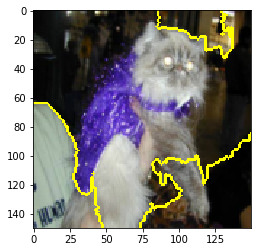

In [267]:
plt.imshow(mark_boundaries(temp, mask, mode='thick'))

(1, 150, 150, 3)


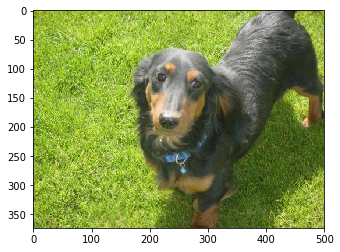

In [18]:
dog_img = load_img('data/dogs_vs_cats/train/training_set/dog/dog.10032.jpg')
# actual image
plt.imshow(dog_img)
img_as_arry = img_to_array(dog_img)
resized = imresize(img_as_arry, (img_width, img_height))
an_img_dog = resized.reshape((1,) + resized.shape)
print(an_img_dog.shape)

In [32]:
predict_result = model.predict(an_img_dog)
print(predict_result)

[[ 1.]]


In [44]:
skater_model = InMemoryModel(model.predict)
explainer = LimeImageExplainer()
explanation2 = explainer.explain_instance(an_img_dog[0], skater_model.prediction_fn, batch_size=5, 
                                         top_labels=2, hide_color=0, num_samples=10000)

2017-08-22 23:50:04,218 - skater.model.base - WARNING - No examples provided, cannot infer model type


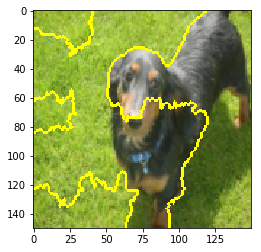

In [54]:
temp2, mask2 = explanation2.get_image_and_mask(label=0, positive_only=True,
                                            num_features=10000, hide_rest=False)

plt.imshow(mark_boundaries(temp2, mask2, mode='thick'))